# Forest Loss Analysis in India
This notebook analyzes forest cover changes in India using Google Earth Engine data.

## Features
- Calculate forest coverage and loss statistics
- Visualize temporal changes
- Generate interactive maps
- Compare regional differences

## Setup
Run this notebook with Python 3.8+ and the following packages:
- earthengine-api
- geemap
- matplotlib
- ipywidgets
- numpy
- pandas

Author: Your Name
Last Updated: September 2025

All Imports

In [1]:
# System imports
import logging
from pathlib import Path

# Data analysis
import ee
import geemap
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Local imports
from config.config import project_name, dataset_name

# Clear any existing log handlers (important in Jupyter notebooks to avoid duplicate logs)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Reconfigure logging to output both to notebook and to a file
logging.basicConfig(
    level=logging.INFO,  # Set logging level to INFO
    format="%(asctime)s - %(levelname)s - %(message)s",  # Log format
    handlers=[
        logging.StreamHandler(),  # Show logs in notebook output
        logging.FileHandler("forest_analysis.log", mode="w"),  # Save logs to file
    ],
)

try:
    # Authenticate with Google Earth Engine (will prompt if not already authenticated)
    ee.Authenticate()
    # Initialize Earth Engine with the specified project
    ee.Initialize(project=project_name)
    logging.info("Successfully authenticated with Earth Engine")
except Exception as e:
    logging.error(f"Failed to authenticate: {str(e)}")
    raise

2025-09-07 22:08:01,473 - INFO - Successfully authenticated with Earth Engine


Accessing Dataset

In [2]:
# Load the forest change dataset as an Earth Engine Image using the dataset name from config
dataset = ee.Image(dataset_name)

# Log the available band names in the dataset for reference and debugging
logging.info(f"{dataset.bandNames().getInfo()}")

2025-09-07 22:08:02,077 - INFO - ['treecover2000', 'loss', 'gain', 'lossyear', 'first_b30', 'first_b40', 'first_b50', 'first_b70', 'last_b30', 'last_b40', 'last_b50', 'last_b70', 'datamask']


Region selection

In [3]:
# Load the administrative boundaries for India states from the FAO GAUL dataset
countries = ee.FeatureCollection("FAO/GAUL/2015/level1")

# Filter the collection to select only Madhya Pradesh by its administrative name
mp = countries.filter(ee.Filter.eq("ADM1_NAME", "Madhya Pradesh"))

# Extract the geometry of Madhya Pradesh to use as the region of interest (ROI)
roi = mp.geometry()

Select useful bands

In [4]:
# Select the relevant bands from the forest change dataset

# Tree cover percentage in the year 2000
treecover2000 = dataset.select("treecover2000")

# Forest loss mask (1 = loss, 0 = no loss)
loss = dataset.select("loss")

# Year of forest loss (values: 1-24, representing 2001-2024)
loss_year = dataset.select("lossyear")

# Forest gain mask (1 = gain, 0 = no gain)
gain = dataset.select("gain")

Forest area info

In [5]:
# Create a binary mask for forest area in the year 2000 (tree cover > 30%)
forest2000 = treecover2000.gt(30)

# Calculate total forest area in 2000 (in square meters) within the ROI
forest_area_2000 = forest2000.multiply(ee.Image.pixelArea()).reduceRegion(
    reducer=ee.Reducer.sum(), geometry=roi, scale=300, maxPixels=1e13
)
logging.info(f"Forest area in 2000: {forest_area_2000.getInfo()['treecover2000']} m²")

# Calculate total forest loss area (2001-2024) within the ROI
loss_area = loss.multiply(ee.Image.pixelArea()).reduceRegion(
    reducer=ee.Reducer.sum(), geometry=roi, scale=300, maxPixels=1e13
)
logging.info(f"Total loss area (2001-2024): {loss_area.getInfo()['loss']} m²")

# Calculate total forest gain area (2001-2024) within the ROI
gain_area = gain.multiply(ee.Image.pixelArea()).reduceRegion(
    reducer=ee.Reducer.sum(), geometry=roi, scale=300, maxPixels=1e13
)
logging.info(f"Total gain area (2001-2024): {gain_area.getInfo()['gain']} m²")

# Define a function to calculate yearly forest loss area for each year
def calc_yearly_loss(year):
    """Calculate forest loss area for a given year."""
    year = ee.Number(year)
    mask = loss_year.eq(year)  # Mask for pixels lost in this year
    area = mask.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=300, maxPixels=1e13
    )
    # Return as a Feature with year and loss area
    return ee.Feature(
        None, {"year": ee.Number(year).add(2000), "loss_area_m2": area.get("lossyear")}
    )


# Generate a list of years (2001-2024)
years = ee.List.sequence(1, 24)

# Map the yearly loss function over all years to get a FeatureCollection
yearly_loss = ee.FeatureCollection(years.map(calc_yearly_loss))

# Convert the FeatureCollection to a Python dictionary for further analysis
loss_dict = yearly_loss.getInfo()

# Log yearly forest loss statistics for each year
for f in loss_dict["features"]:
    logging.info(f"{f['properties']}")

2025-09-07 22:08:03,064 - INFO - Forest area in 2000: 8936065791.026289 m²
2025-09-07 22:08:04,024 - INFO - Total loss area (2001-2024): 174222282.0176777 m²
2025-09-07 22:08:05,815 - INFO - Total gain area (2001-2024): 0 m²
2025-09-07 22:08:06,839 - INFO - {'loss_area_m2': 7732488.7634191215, 'year': 2001}
2025-09-07 22:08:06,840 - INFO - {'loss_area_m2': 5494800.970833331, 'year': 2002}
2025-09-07 22:08:06,840 - INFO - {'loss_area_m2': 5730479.768995095, 'year': 2003}
2025-09-07 22:08:06,841 - INFO - {'loss_area_m2': 7650368.632291665, 'year': 2004}
2025-09-07 22:08:06,841 - INFO - {'loss_area_m2': 9719857.335324734, 'year': 2005}
2025-09-07 22:08:06,842 - INFO - {'loss_area_m2': 11627351.68820465, 'year': 2006}
2025-09-07 22:08:06,843 - INFO - {'loss_area_m2': 8330279.282720587, 'year': 2007}
2025-09-07 22:08:06,843 - INFO - {'loss_area_m2': 8450531.399571076, 'year': 2008}
2025-09-07 22:08:06,844 - INFO - {'loss_area_m2': 6873404.789093139, 'year': 2009}
2025-09-07 22:08:06,844 - I

Visualization

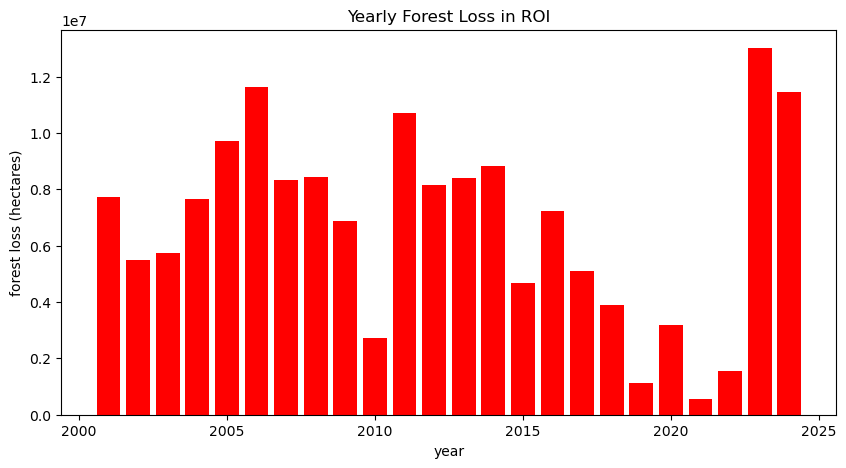

In [6]:
# Prepare lists to store years and corresponding forest loss areas
years_list, area_list = [], []

# Extract year and loss area from each feature in the loss dictionary
for f in loss_dict["features"]:
    years_list.append(f["properties"]["year"])
    area_list.append(f["properties"]["loss_area_m2"])

# Plot the yearly forest loss as a bar chart
plt.figure(figsize=(10, 5))
plt.bar(years_list, area_list, color="red")
plt.xlabel("year")
plt.ylabel("forest loss (hectares)")
plt.title("Yearly Forest Loss in ROI")
plt.show()

In [7]:
# Create an interactive map centered on India
Map = geemap.Map(center=[20, 0], zoom=2)

# Visualization parameters for different layers
trecover_vis = {"min": 0, "max": 100, "palette": ["white", "green"]}  # Tree cover
loss_vis = {"min": 0, "max": 1, "palette": ["white", "red"]}          # Forest loss
loss_year_vis = {"min": 1, "max": 24, "palette": ["yellow", "orange", "red"]}  # Year of loss

# Apply masks to show only relevant pixels for each layer
forest2000_masked = treecover2000.updateMask(forest2000)  # Only show forested areas in 2000
loss_masked = loss.updateMask(loss)                       # Only show pixels where loss=1
gain_masked = gain.updateMask(gain)                       # Only show pixels where gain=1
loss_year_masked = loss_year.updateMask(loss)             # Only show year where loss occurred

# Add layers to the map for visualization
Map.addLayer(forest2000_masked, trecover_vis, "Tree cover 2000")
Map.addLayer(loss_masked, loss_vis, "Forest Loss")
Map.addLayer(gain_masked, {"palette": ["blue"]}, "Forest Gain")
Map.addLayer(loss_year_masked, loss_year_vis, "Year of Loss (2001-2024)")
Map.addLayer(roi, {"color": "black"}, "ROI")  # Region of interest boundary

# Display the map
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', trans…

India Forest Loss Time Series

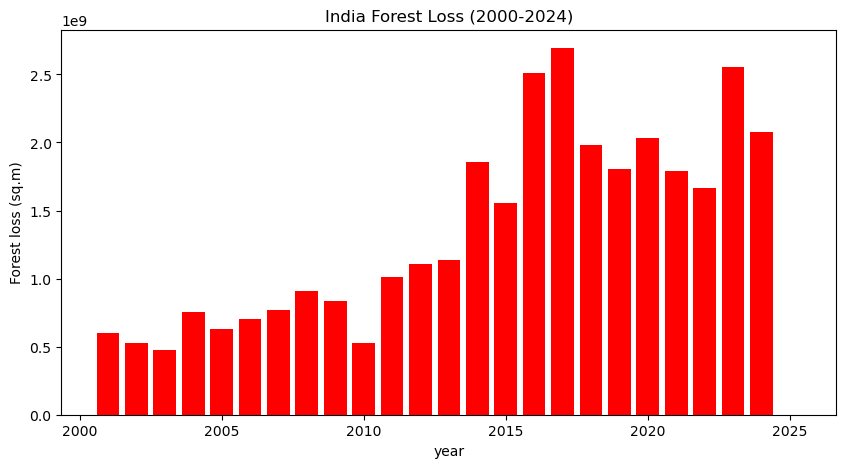

In [8]:
# --- India Forest Loss Time Series ---

# Load country boundaries from USDOS dataset
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")

# Filter for India and get its geometry
india = countries.filter(ee.Filter.eq("country_na", "India")).first()
roi = india.geometry()

# Function to calculate forest loss area for a given year
def year_loss(year):
    year = ee.Number(year)
    loss_mask = loss_year.eq(year)  # Mask for pixels lost in this year

    # Calculate area of loss for the year within India's geometry
    area = loss_mask.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=300,
        maxPixels=1e13,
        bestEffort=True,
    )

    # Return as a Feature with year and loss area
    return ee.Feature(
        None, {"year": year.add(2000), "loss_area_m2": area.get("lossyear")}
    )

# List of years (2001-2025, as loss_year starts from 1)
years = ee.List.sequence(1, 25)

# Map the year_loss function over all years to get a FeatureCollection
fc = ee.FeatureCollection(years.map(year_loss))

# Get the results as a Python dictionary
loss_stats = fc.getInfo()

# Prepare lists for plotting
years_list, area_list = [], []
for f in loss_stats["features"]:
    years_list.append(f["properties"]["year"])
    area_list.append(f["properties"]["loss_area_m2"])

# Plot the yearly forest loss for India
plt.figure(figsize=(10, 5))
plt.bar(years_list, area_list, color="red")
plt.xlabel("year")
plt.ylabel("Forest loss (sq.m)")
plt.title("India Forest Loss (2000-2024)")
plt.show()

Year-Wise Forest Loss Map

In [9]:
# Create an interactive map centered on India
Map = geemap.Map(center=[20, 0], zoom=2)

# Visualization parameters for different layers
trecover_vis = {"min": 0, "max": 100, "palette": ["white", "green"]}  # Tree cover
loss_vis = {"min": 0, "max": 1, "palette": ["white", "red"]}          # Forest loss
loss_year_vis = {"min": 1, "max": 24, "palette": ["yellow", "orange", "red"]}  # Year of loss

# Apply masks to show only relevant pixels for each layer
forest2000_masked = treecover2000.updateMask(forest2000)  # Only show forested areas in 2000
loss_masked = loss.updateMask(loss)                       # Only show pixels where loss=1
gain_masked = gain.updateMask(gain)                       # Only show pixels where gain=1
loss_year_masked = loss_year.updateMask(loss)             # Only show year where loss occurred

# Add layers to the map for visualization
Map.addLayer(forest2000_masked, trecover_vis, "Tree cover 2000")
Map.addLayer(loss_masked, loss_vis, "Forest Loss")
Map.addLayer(gain_masked, {"palette": ["blue"]}, "Forest Gain")
Map.addLayer(loss_year_masked, loss_year_vis, "Year of Loss (2001-2024)")
Map.addLayer(roi, {"color": "black"}, "ROI")  # Region of interest boundary

# Display the map
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', trans…